Adjusted StepLR: initial learning rate (lr) = 0.0005, decay to 0.9 times the current rate every 200 epochs.

training start!
Epoch [20/300], D Loss: -0.8417, G Loss: 0.4373


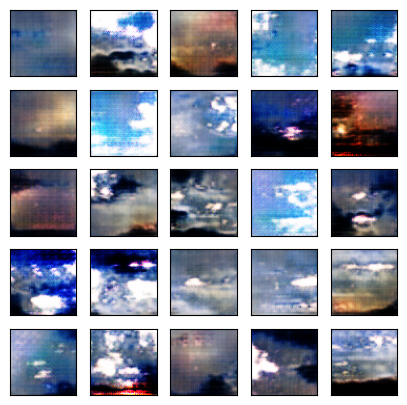

Epoch [40/300], D Loss: -0.7745, G Loss: 0.2076


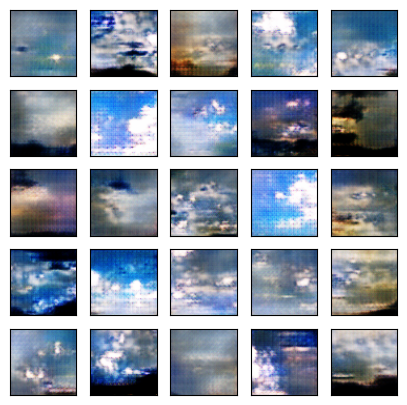

Epoch [60/300], D Loss: -0.7161, G Loss: 0.4456


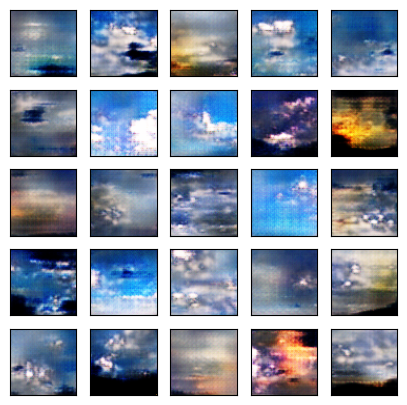

Epoch [80/300], D Loss: -0.6894, G Loss: 0.0955


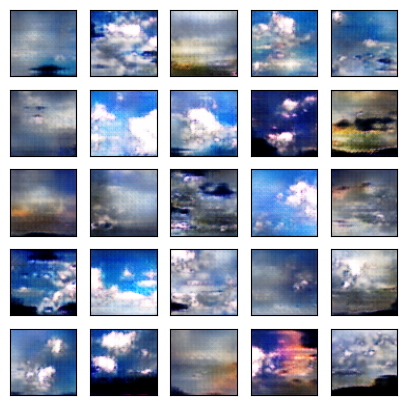

Epoch [100/300], D Loss: -0.6601, G Loss: 0.0945


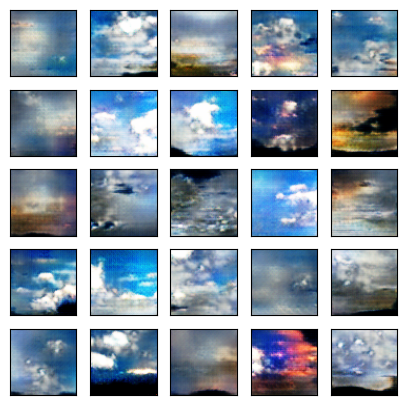

Epoch [120/300], D Loss: -0.4285, G Loss: 0.4399


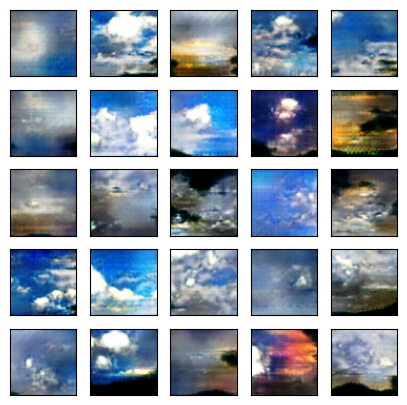

Epoch [140/300], D Loss: -0.1176, G Loss: 0.1055


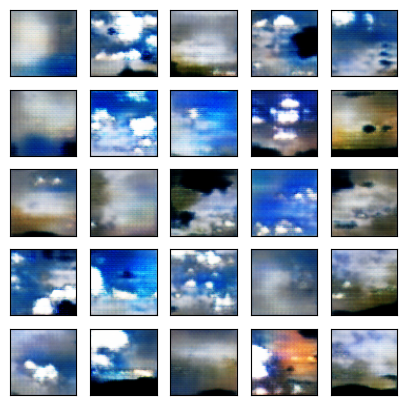

Epoch [160/300], D Loss: -0.2289, G Loss: 0.1186


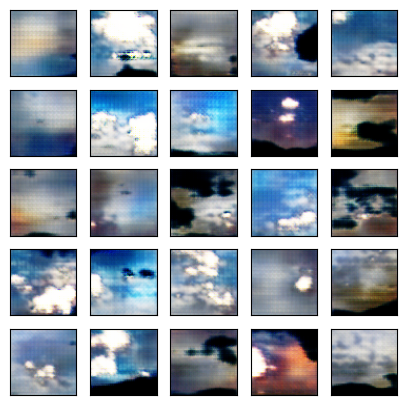

Epoch [180/300], D Loss: -0.2408, G Loss: 0.0692


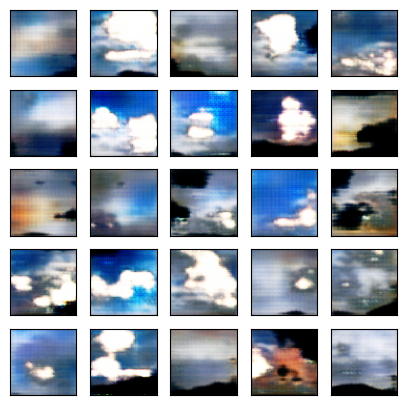

Epoch [200/300], D Loss: -0.4112, G Loss: 0.2309


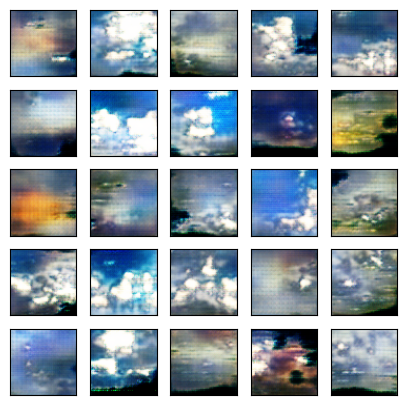

Epoch [220/300], D Loss: -0.1198, G Loss: 0.0199


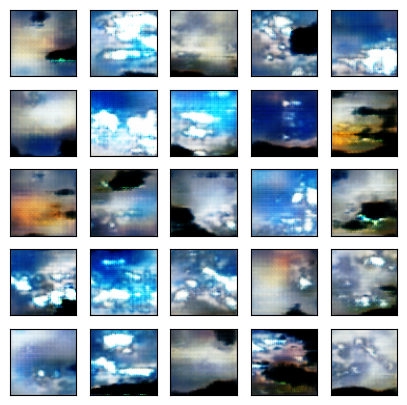

Epoch [240/300], D Loss: -0.1132, G Loss: 0.1145


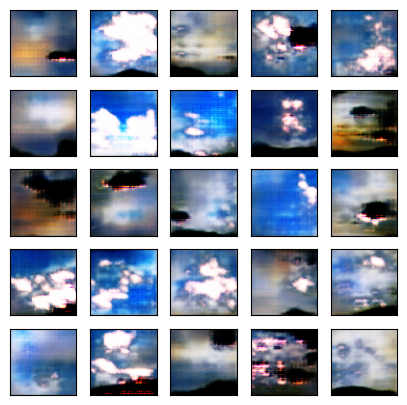

Epoch [260/300], D Loss: -0.1359, G Loss: 0.0448


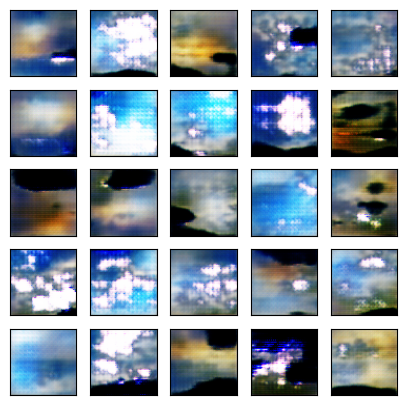

Epoch [280/300], D Loss: -0.0799, G Loss: 0.0004


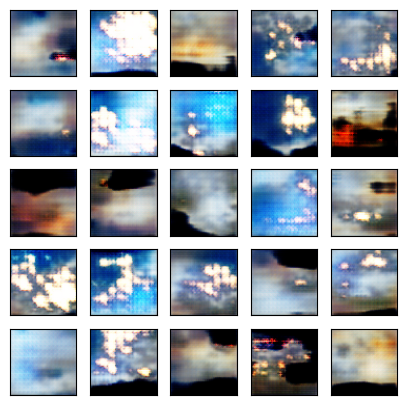

Epoch [300/300], D Loss: -0.3478, G Loss: 0.2635


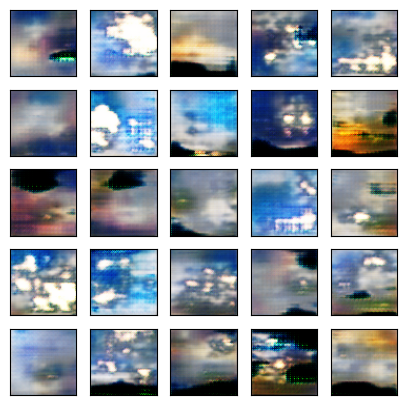

Total training time: 797.90s


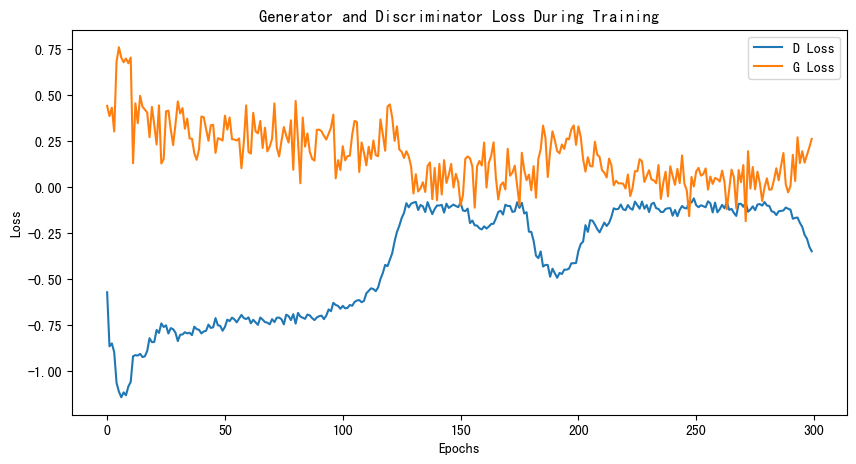

In [2]:
import os, time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler


class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if
                            f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class generator(nn.Module):
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x

class discriminator(nn.Module):
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x) 
        return x

batch_size = 32
lr = 0.0005
train_epoch = 300
img_size = 64
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'cloud'
cloud_dataset = CloudDataset(root_dir, transform=transform)
train_loader = DataLoader(cloud_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

G = generator(128).cuda()
D = discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G_optimizer = optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=lr)

G_scheduler = lr_scheduler.StepLR(G_optimizer, step_size=200, gamma=0.9)
D_scheduler = lr_scheduler.StepLR(D_optimizer, step_size=200, gamma=0.9)

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []


print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for x_ in train_loader:
        mini_batch = x_.size()[0]
        x_ = x_.cuda()

        for _ in range(5): 
            z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
            fake_data = G(z_)

            D_real = D(x_).mean()
            D_fake = D(fake_data.detach()).mean()

            D_train_loss = -(D_real - D_fake)
            D_optimizer.zero_grad()
            D_train_loss.backward()
            D_optimizer.step()

            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)

            D_epoch_losses.append(D_train_loss.item())

        G.zero_grad()
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).mean()  
        G_train_loss = -D_result  
        G_train_loss.backward()
        G_optimizer.step()
        G_epoch_losses.append(G_train_loss.item())

    if (epoch + 1) % 20 == 0:
        print(
            f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2
            test_images = torch.clamp(test_images, 0, 1)
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())
    G_scheduler.step()
    D_scheduler.step()

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss function in this training looks much more normal, and the generated results are acceptable. 
However, I'm not sure why there are some black areas in the images; 
I'm certain they are not dark clouds, as there are no dark cloud samples in the training dataset. 
I'm not sure if this is related to the dataset, the GAN model, or the GPU. 
Anyway, I will try using a different dataset first.